# Model training for NFL play prediction

---
 
In this notebook, we train multiple regression and ANN models to predict the yards gained per football play. As a basis we use the preselected data created by the `preprocessing.py``.

### Inline preprocessing steps:

---

As we use 5-fold cross-validation to protect the model against overfitting, we need a dynamic preprocessing appraoch. Therefore a pipeline provided by the `preprocessing.py`` will be used to process the training data of each fold. Further we use a nested cross validation to ensure the quality of our model using selected hyperparameters.


### Contributors

All contributors are only assigned to their primary task, the teams still interchanged know-how and worked on one anothers approaches.

---

##### Preprocessing Team

- Tim Oliver Krause (1689074)
- Jan Thilo Viktorin (1684159)
- Joël Pflomm (1634591)

##### Model Team

- Franziska Köllschen (1981780)
- Steffen Hüls (1979863)
- Matthias Biermanns (1980701)

## Coding

### Coding Foundations

In [7]:
# basic imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.base import TransformerMixin, BaseEstimator
import preprocessing

# import for data visualization
import matplotlib.pyplot as plt

# imports for regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb

In [8]:
# static variables
FILE_LIST = [f'./Data/play_by_play_{year}.csv' for year in range(2020, 2024)]
PREPROCESSOR = preprocessing.NFLPreprocessing(FILE_LIST)
TARGET_NAME = 'yards_gained'
RANDOM_STATE = 42
LABEL_PASS = 'Pass'
LABEL_RUN = 'Run'

2023-12-02 14:46:23.000 | INFO     | preprocessing:__init__:58 - --- Executing Preprocessing Steps ---
2023-12-02 14:46:23.001 | INFO     | preprocessing:make_combined_df:152 - Loading csv files
c:\Users\mbier\VSCodeProjects\NFL_play_prediction\preprocessing.py:157: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,213,214,218,219,220,222,224,226,248,249,253,254,255,260,262,263,266,267,268,269,283,284,301) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
c:\Users\mbier\VSCodeProjects\NFL_play_prediction\preprocessing.py:157: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,233,234,235,236,237,238,248,249,253,254,255,260,262,263,283,284,301) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
c:\Users\mbier\VSCodeProjects\NFL_play_prediction\preprocessing.py:157: DtypeWarning: Columns (179,180,182,183,189,190,193,

##### General functions

In [9]:
def split_feature_target(df, data_fraction=1):
    # set fraction between 0 and 1 (e.g. 0.05 -> 5% df)
    df_sampled = df.sample(frac=data_fraction, random_state=RANDOM_STATE)

    # Reset the index if needed
    df_sampled = df_sampled.reset_index(drop=True)

    features = df_sampled.drop(TARGET_NAME, axis=1)
    target = df_sampled[TARGET_NAME]

    return features, target

def visualize_predicts(y_test, predictions, label):
    # Visualize predictions for passes
    plt.scatter(y_test, predictions)
    plt.title(label + ' Model: True vs Predicted Yards')
    plt.xlabel('True Yards')
    plt.ylabel('Predicted Yards')
    plt.show()

def plot_decision_tree(tree, label):
    # Plot the decision tree for runs
    plt.figure(figsize=(15, 10))
    plot_tree(tree, filled=True, feature_names=PREPROCESSOR.get_prepro_feature_names_from_pipeline())
    plt.title('Decision Tree for ' + label + ' Model')
    plt.show()

def visualize_train_val_loss(training_losses, validation_losses, label):
    # Plot the training and validation loss
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Neural Network Training and Validation Loss - ' + label)
    plt.legend()
    plt.show()

##### Functions for cross validation

In [10]:
def test_model(pipeline, x_train, y_train, x_test, y_test):
    pipeline.fit(x_train, y_train)

    # Make predictions on the test set
    predictions = pipeline.predict(x_test)

    # Evaluate the models
    pass_mse = mean_squared_error(y_test, predictions)
    pass_rmse = mean_squared_error(y_test, predictions, squared = False)
    pass_msa = mean_absolute_error(y_test, predictions)

    print(f"Mean Squared Error: {pass_mse}")
    print(f"Mean Absolute Error: {pass_msa}")
    print(f"Root Mean Squared Error: {pass_rmse}")
    return predictions

def test_model_k_fold(df, pipeline, data_fraction, k_folds=5):
    features, target = split_feature_target(df, data_fraction)
    
    cv_results = cross_val_predict(pipeline, features, target, cv=k_folds)
    #print(f"Run Model Cross-Validation Mean Squared Error: {np.mean(cv_results)}")
    #print(f"Run Model Cross-Validation Max Squared Error: {np.max(cv_results)}")
    return cv_results

def estimate_hyperparams(features, target, pipeline, scoring, k_folds=5, parameters={}):
    # create the grid search instance
    grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=scoring, cv=k_folds, return_train_score=False)

    # run the grid search
    grid_search_estimator.fit(features, target)

    return grid_search_estimator

##### MLP Regressor Class - with history

In [11]:
class MLPWithHistory(BaseEstimator, TransformerMixin):
    def __init__(self, mlp_params=None):
        self.mlp_params = mlp_params
        self.training_losses = []
        self.validation_losses = []
        self.mlp_regressor = MLPRegressor(**(self.mlp_params or {}))

    def fit(self, X, y):
        X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        for epoch in range(self.mlp_regressor.max_iter):
            self.mlp_regressor.partial_fit(X, y)

            # Calculate training loss
            y_train_pred = self.mlp_regressor.predict(X)
            training_loss = mean_squared_error(y, y_train_pred)
            self.training_losses.append(training_loss)

            # Calculate validation loss
            y_val_pred = self.mlp_regressor.predict(X_val)
            validation_loss = mean_squared_error(y_val, y_val_pred)
            self.validation_losses.append(validation_loss)

        return self

    def transform(self, X):
        return X

    def predict(self, X):
        return self.mlp_regressor.predict(X)

    def get_params(self, deep=True):
        return {"mlp_params": self.mlp_params}

    def set_params(self, **params):
        self.mlp_params = params["mlp_params"]
        self.mlp_regressor.set_params(**self.mlp_params)
        return self
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return -mean_squared_error(y, y_pred)

##### Train and Test Data

In [12]:
run_df = PREPROCESSOR.run_df
pass_df = PREPROCESSOR.pass_df

run_features, run_target = split_feature_target(run_df, 0.2)
pass_features, pass_target = split_feature_target(pass_df, 0.2)

run_X_train, run_X_test, run_y_train, run_y_test = train_test_split(run_features, run_target)
pass_X_train, pass_X_test, pass_y_train, pass_y_test = train_test_split(pass_features, pass_target)

print(run_features.shape)
print(pass_features.shape)

run_features

(10204, 28)
(12925, 28)


,season_type,posteam,posteam_type,defteam,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,down,goal_to_go,...,td_prob,first_down_rush,first_down_pass,season,drive_play_count,drive_start_yard_line,spread_line,total_line,div_game,roof
0,REG,PIT,away,LA,54.0,283.0,283.0,2083.0,1.0,0,...,0.402933,0.0,0.0,2023,5.0,25,-3.5,44.0,0,dome
1,REG,IND,home,PHI,50.0,664.0,664.0,664.0,3.0,0,...,0.437069,0.0,0.0,2022,5.0,25,-6.5,45.5,0,closed
2,REG,DAL,home,SF,74.0,834.0,1734.0,1734.0,3.0,0,...,0.334126,0.0,0.0,2020,3.0,25,-4.0,46.0,0,closed
3,REG,MIN,home,DET,15.0,176.0,176.0,1976.0,1.0,0,...,0.585632,0.0,0.0,2021,8.0,12,10.0,49.5,1,dome
4,REG,NE,away,LA,75.0,681.0,1581.0,3381.0,1.0,0,...,0.381713,0.0,0.0,2020,3.0,25,-5.0,43.5,0,dome
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10199,REG,CIN,away,ARI,6.0,519.0,1419.0,3219.0,1.0,0,...,0.745954,0.0,0.0,2023,11.0,36,3.0,45.5,0,closed
10200,REG,SEA,away,PHI,52.0,285.0,285.0,285.0,3.0,0,...,0.220055,0.0,0.0,2020,7.0,20,6.5,50.0,0,outdoors
10201,REG,JAX,away,DET,75.0,635.0,1535.0,1535.0,1.0,0,...,0.379884,0.0,0.0,2022,16.0,25,-1.0,51.5,0,dome
10202,REG,SF,away,DAL,52.0,210.0,210.0,210.0,1.0,0,...,0.338100,0.0,0.0,2020,4.0,29,4.0,46.0,0,closed


### Linear Regression

In [13]:
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_pipeline

Pipeline(steps=[('outlier_remover',
                 FunctionSampler(func=<bound method NFLPreprocessing.outlier_sampler_iqr of <preprocessing.NFLPreprocessing object at 0x0000021257581310>>,
                                 validate=False)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['posteam', 'posteam_type',
                                                   'defteam', 'roof',
                                                   'season_type']),
                                                 ('standardization',
                                                  StandardScaler(),
                                                  ['score_differential']),
                                                 ('minmax', MinMaxScaler(),
                                                  ['yardline_100',
                                                   'game_seconds_remaining',
                                                   'down', 'ydstogo', 'td_prob',
                                                   'spread_line', 'total_line',
                                                   'season',
                                                   'posteam_timeouts_remaining',
                                                   'defteam_timeouts_remaining',
                                                   'quarter_seconds_remaining',
                                                   'half_seconds_remaining',
                                                   'drive_start_yard_line'])]))])

Mean Squared Error: 39.40920529288606
Mean Absolute Error: 3.8511173791290774
Root Mean Squared Error: 6.277675150315287
Mean Squared Error: 87.61815737868602
Mean Absolute Error: 6.801105023193704
Root Mean Squared Error: 9.36045711376779


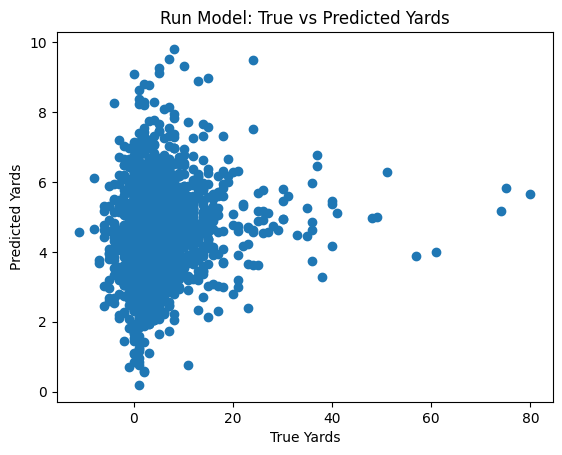

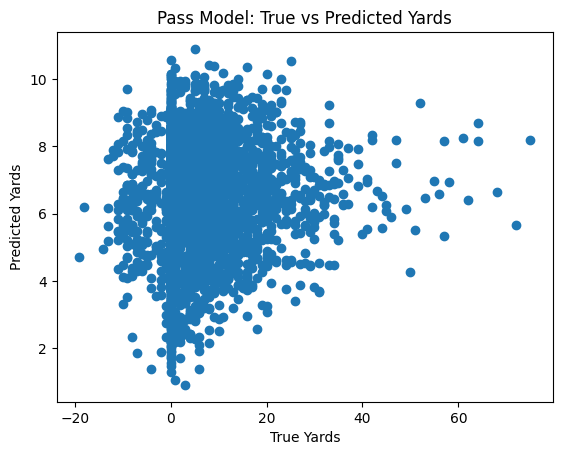

In [14]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_params = {
    'outlier_remover__kw_args': {
        'strict_factor_iqr': 1.0,
        'loose_factor_iqr': 2.0,
        'strict_columns': ['yardline_100', 'ydstogo'],
        'omit_columns': []
    }
}

pass_params = {
    'outlier_remover__kw_args': {
        'strict_factor_iqr': 1.5,
        'loose_factor_iqr': 3.0,
        'strict_columns': ['ydstogo'],
        'omit_columns': []
    }
}

# add model to pipeline
pipeline.steps.append(("regression", LinearRegression()))

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model(pipeline, run_X_train, run_y_train, run_X_test, run_y_test)


# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model(pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# visualize predictions
visualize_predicts(run_y_test, run_predictions, LABEL_RUN)
visualize_predicts(pass_y_test, pass_predictions, LABEL_PASS)

In [9]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline()

# add model to pipeline
pipeline.steps.append(("regression", LinearRegression()))

run_cv_scores = cross_val_score(pipeline, run_features, run_target, cv=5, scoring='neg_mean_squared_error')
print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(run_cv_scores)}")


Run Model Cross-Validation Mean Squared Error: 38.19495395134794


In [16]:
# hyperparameter tuning for linear regression

# could be more over engineered with automatic dict creation if necessary
run_params = {
    'outlier_remover__kw_args': [
        {
            'strict_factor_iqr': 1.0,
            'loose_factor_iqr': 2.0,
            'strict_columns': ['yardline_100', 'ydstogo'],
            'omit_columns': []
        }, {
            'strict_factor_iqr': 1.5,
            'loose_factor_iqr': 3.0,
            'strict_columns': ['yardline_100', 'ydstogo'],
            'omit_columns': []
        },
    ]
}

pass_params = {
    'outlier_remover__kw_args': [{
        'strict_factor_iqr': 1.5,
        'loose_factor_iqr': 3.0,
        'strict_columns': ['ydstogo'],
        'omit_columns': []
    }]
}

pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pipeline.steps.append(('regression', LinearRegression()))

run_grid_search = estimate_hyperparams(run_features, run_target, pipeline, scoring='neg_mean_squared_error', parameters=run_params)
pass_grid_search = estimate_hyperparams(pass_features, pass_target, pipeline, scoring='neg_mean_squared_error', parameters=pass_params)

display(run_grid_search.best_params_)
display(pd.DataFrame(run_grid_search.cv_results_))
display(pass_grid_search.best_params_)
display(pd.DataFrame(pass_grid_search.cv_results_))

{'outlier_remover__kw_args': {'strict_factor_iqr': 1.5,
  'loose_factor_iqr': 3.0,
  'strict_columns': ['yardline_100', 'ydstogo'],
  'omit_columns': []}}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_outlier_remover__kw_args,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.034028,0.002997,0.014268,0.016779,"{'strict_factor_iqr': 1.0, 'loose_factor_iqr':...",{'outlier_remover__kw_args': {'strict_factor_i...,-39.031327,-39.440846,-38.424894,-36.540328,-38.106546,-38.308788,0.998544,2
1,0.033289,0.001233,0.005605,0.000801,"{'strict_factor_iqr': 1.5, 'loose_factor_iqr':...",{'outlier_remover__kw_args': {'strict_factor_i...,-39.087410,-39.357173,-38.222847,-36.447496,-37.982901,-38.219565,1.024066,1


{'outlier_remover__kw_args': {'strict_factor_iqr': 1.5,
  'loose_factor_iqr': 3.0,
  'strict_columns': ['ydstogo'],
  'omit_columns': []}}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_outlier_remover__kw_args,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.042943,0.002974,0.006405,0.000663,"{'strict_factor_iqr': 1.5, 'loose_factor_iqr':...",{'outlier_remover__kw_args': {'strict_factor_i...,-84.369383,-88.556428,-104.384134,-99.775602,-96.274331,-94.671976,7.300464,1


Mean Squared Error: 33.06093958137518
Mean Absolute Error: 3.7709004095085072
Root Mean Squared Error: 5.7498643098229
Mean Squared Error: 92.62657909003275
Mean Absolute Error: 6.9383079908108005
Root Mean Squared Error: 9.624270314680109


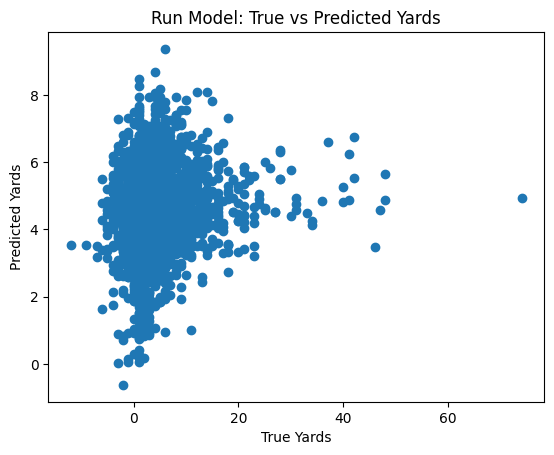

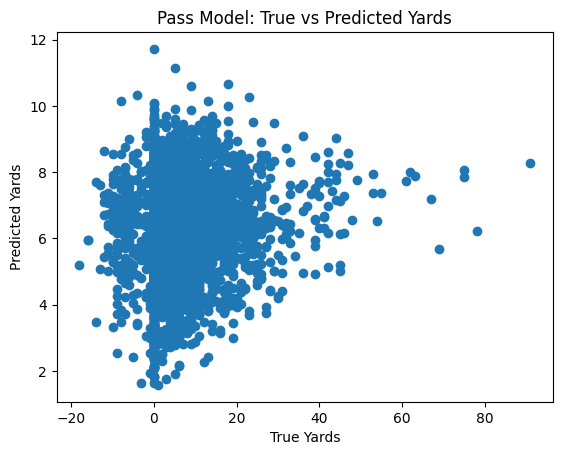

In [17]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# add model to pipeline
pipeline.steps.append(("regression", LinearRegression()))

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model(pipeline, run_X_train, run_y_train, run_X_test, run_y_test)


# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model(pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# visualize predictions
visualize_predicts(run_y_test, run_predictions, LABEL_RUN)
visualize_predicts(pass_y_test, pass_predictions, LABEL_PASS)

### Polynomial Regression

In [13]:
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['posteam', 'posteam_type',
                                                   'defteam', 'roof',
                                                   'season_type']),
                                                 ('outlier_remover',
                                                  Pipeline(steps=[('outlier_remover',
                                                                   FunctionSampler(func=<bound method NFLPreprocessing.outlier_sampler_iqr of <preprocessing.NFLPreprocessing ob...
                                                  Pipeline(steps=[('standardization',
                                                                   StandardScaler())]),
                                                  ['score_differential']),
                                                 ('minmax',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['yardline_100',
                                                   'game_seconds_remaining',
                                                   'down', 'ydstogo', 'td_prob',
                                                   'spread_line', 'total_line',
                                                   'season',
                                                   'posteam_timeouts_remaining',
                                                   'defteam_timeouts_remaining',
                                                   'quarter_seconds_remaining',
                                                   'half_seconds_remaining',
                                                   'drive_start_yard_line'])]))])

Mean Squared Error: 41.72882445102919
Mean Absolute Error: 4.141732605260445
Root Mean Squared Error: 6.459785170656157
Mean Squared Error: 104.42414908037658
Mean Absolute Error: 7.309790456417346
Root Mean Squared Error: 10.218813486916012


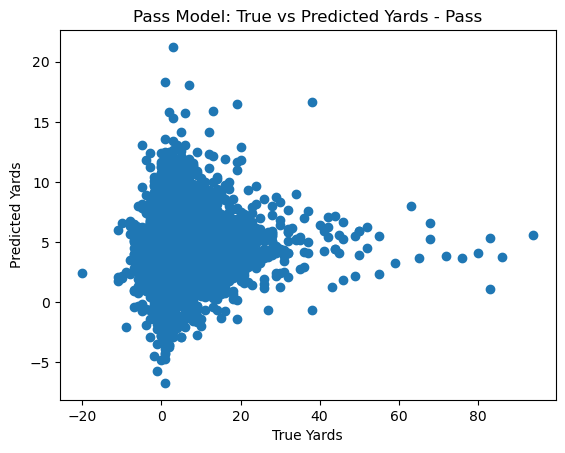

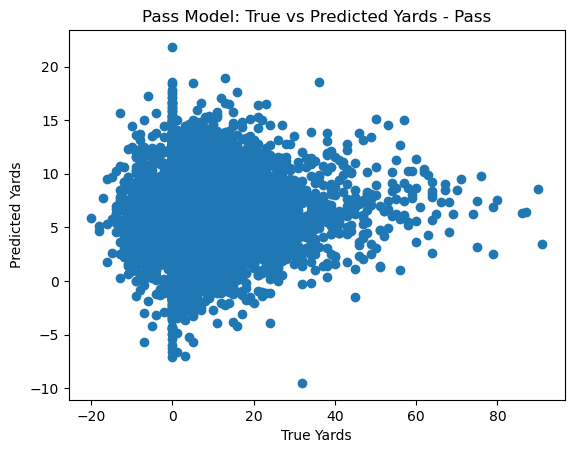

In [16]:
# basic model

# make pipelines from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

# add model to pipeline
run_pipeline.steps.append(("regression", make_pipeline(PolynomialFeatures(2), LinearRegression())))
pass_pipeline.steps.append(("regression", make_pipeline(PolynomialFeatures(2), LinearRegression())))

# test model and save predictions
run_predictions = test_model(run_pipeline, run_X_train, run_y_train, run_X_test, run_y_test)
pass_predictions = test_model(pass_pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# visualize predictions
visualize_predicts(run_y_test, run_predictions, LABEL_RUN)
visualize_predicts(pass_y_test, pass_predictions, LABEL_PASS)

In [171]:
# estimating hyperparameters

run_features, run_target = split_feature_target(run_df, 0.01)
pass_features, pass_target = split_feature_target(pass_df, 0.01)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_features = run_pipeline.fit_transform(run_features, run_target)
pass_features = pass_pipeline.fit_transform(pass_features, pass_target)

run_model = make_pipeline(PolynomialFeatures(), LinearRegression())
pass_model = make_pipeline(PolynomialFeatures(), LinearRegression())

parameters = {
    'polynomialfeatures__degree': [2, 3]
}

run_estimator = estimate_hyperparams(run_features, run_target, run_model, 0.05, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)
pass_estimator = estimate_hyperparams(pass_features, pass_target, pass_model, 0.05, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)

display(run_estimator.best_params_)
display(pass_estimator.best_params_)

{'polynomialfeatures__degree': 3}

{'polynomialfeatures__degree': 3}

In [172]:
# cross-validation with best hyperparameters

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_pipeline.steps.append(("regressor", make_pipeline(
    PolynomialFeatures(degree=run_estimator.best_params_['polynomialfeatures__degree']), 
    LinearRegression()
)))
pass_pipeline.steps.append(("regressor", make_pipeline(
    PolynomialFeatures(degree=pass_estimator.best_params_['polynomialfeatures__degree']), 
    LinearRegression()
)))

run_cv_scores = cross_val_score(run_pipeline, run_features, run_target, cv=5, scoring='neg_mean_squared_error')
print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(run_cv_scores)}")
pass_cv_scores = cross_val_score(pass_pipeline, pass_features, pass_target, cv=5, scoring='neg_mean_squared_error')
print(f"Pass Model Cross-Validation Mean Squared Error: {-np.mean(pass_cv_scores)}")

Run Model Cross-Validation Mean Squared Error: 136.11672497702932


KeyboardInterrupt: 

### KNN

Mean Squared Error: 49.317966810401145
Mean Absolute Error: 4.590043120344963
Root Mean Squared Error: 7.022675189014593
Mean Squared Error: 121.75993893255762
Mean Absolute Error: 8.029378391202988
Root Mean Squared Error: 11.034488612190309


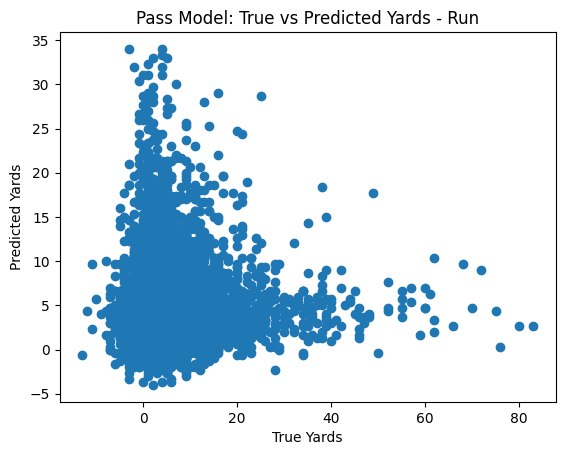

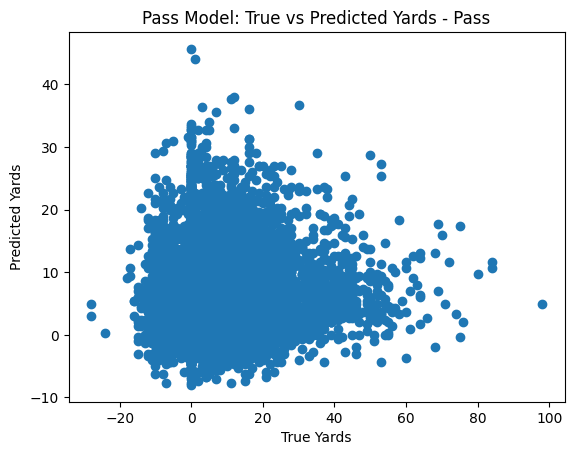

In [10]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

# append KNeighborsRegressor to pipeline
run_pipeline.steps.append(("regression", KNeighborsRegressor(n_neighbors=3)))
pass_pipeline.steps.append(("regression", KNeighborsRegressor(n_neighbors=3)))

# test model and save predictions
run_predictions = test_model(run_pipeline, run_X_train, run_y_train, run_X_test, run_y_test)
pass_predictions = test_model(pass_pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# visualize predictions
visualize_predicts(run_y_test, run_predictions, LABEL_RUN)
visualize_predicts(pass_y_test, pass_predictions, LABEL_PASS)

In [166]:
# estimating hyperparameters

run_features, run_target = split_feature_target(run_df, 0.1)
pass_features, pass_target = split_feature_target(pass_df, 0.1)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_features = run_pipeline.fit_transform(run_features, run_target)
pass_features = pass_pipeline.fit_transform(pass_features, pass_target)

run_model = KNeighborsRegressor()
pass_model = KNeighborsRegressor()

parameters = {
    'n_neighbors': range(1, 10)
}

run_estimator = estimate_hyperparams(run_features, run_target, run_model, 0.05, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)
pass_estimator = estimate_hyperparams(pass_features, pass_target, pass_model, 0.05, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)

display(run_estimator.best_params_)
display(pass_estimator.best_params_)

{'n_neighbors': 9}

{'n_neighbors': 9}

In [168]:
# cross-validation with best hyperparameters

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_pipeline.steps.append(("regressor", KNeighborsRegressor(run_estimator.best_params_['n_neighbors'])))
pass_pipeline.steps.append(("regressor", KNeighborsRegressor(pass_estimator.best_params_['n_neighbors'])))

run_cv_scores = cross_val_score(run_pipeline, run_features, run_target, cv=5, scoring='neg_mean_squared_error')
print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(run_cv_scores)}")
pass_cv_scores = cross_val_score(pass_pipeline, pass_features, pass_target, cv=5, scoring='neg_mean_squared_error')
print(f"Pass Model Cross-Validation Mean Squared Error: {-np.mean(pass_cv_scores)}")

Run Model Cross-Validation Mean Squared Error: 41.15833694740799
Run Model Cross-Validation Mean Squared Error: 98.96113022019077


### Random Forest

Mean Squared Error: 40.18128052003145
Mean Absolute Error: 3.7168201003921983
Root Mean Squared Error: 6.3388706028780435
Mean Squared Error: 96.45084312076595
Mean Absolute Error: 7.006306369168536
Root Mean Squared Error: 9.820939014206633


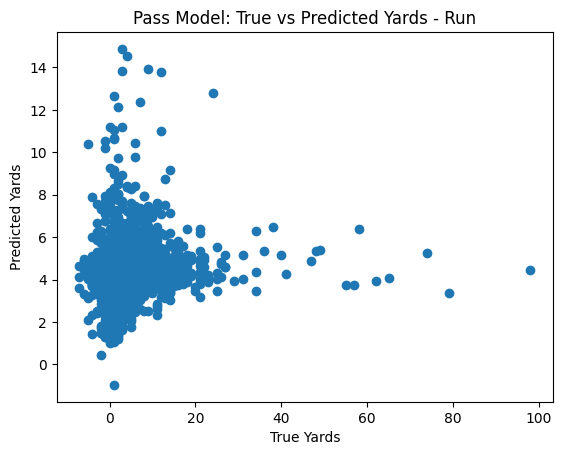

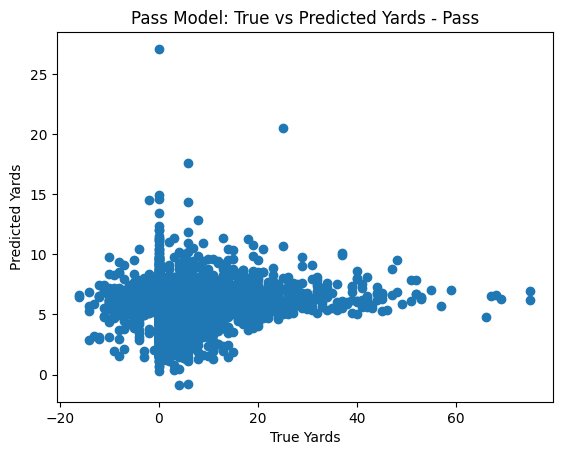

In [13]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_pipeline.steps.append(("regressor", RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)))
pass_pipeline.steps.append(("regressor", RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)))

# test model and save predictions
run_predictions = test_model(run_pipeline, run_X_train, run_y_train, run_X_test, run_y_test)
pass_predictions = test_model(pass_pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# visualize predictions
visualize_predicts(run_y_test, run_predictions, LABEL_RUN)
visualize_predicts(pass_y_test, pass_predictions, LABEL_PASS)

In [42]:
# estimating hyperparameters

run_features, run_target = split_feature_target(run_df, 0.01)
pass_features, pass_target = split_feature_target(pass_df, 0.01)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_features = run_pipeline.fit_transform(run_features, run_target)
pass_features = pass_pipeline.fit_transform(pass_features, pass_target)

run_model = RandomForestRegressor()
pass_model = RandomForestRegressor()

parameters = {
    'max_depth': range(4, 7),
    'n_estimators': [20, 50, 100]
}

run_estimator = estimate_hyperparams(run_features, run_target, run_model, 0.05, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)
pass_estimator = estimate_hyperparams(pass_features, pass_target, pass_model, 0.05, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)

display(run_estimator.best_params_)
display(pass_estimator.best_params_)

{'max_depth': 5, 'n_estimators': 50}

{'max_depth': 6, 'n_estimators': 100}

In [176]:
# cross-validation with best hyperparameters

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_pipeline.steps.append(("regressor", RandomForestRegressor(
    max_depth=run_estimator.best_params_['max_depth'],
    n_estimators=run_estimator.best_params_['n_estimators'],
)))
pass_pipeline.steps.append(("regressor", RandomForestRegressor(
    max_depth=pass_estimator.best_params_['max_depth'],
    n_estimators=pass_estimator.best_params_['n_estimators'],
)))

run_cv_scores = cross_val_score(run_pipeline, run_features, run_target, cv=5, scoring='neg_mean_squared_error')
print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(run_cv_scores)}")
pass_cv_scores = cross_val_score(pass_pipeline, pass_features, pass_target, cv=5, scoring='neg_mean_squared_error')
print(f"Pass Model Cross-Validation Mean Squared Error: {-np.mean(pass_cv_scores)}")

Run Model Cross-Validation Mean Squared Error: 34.503509110877765
Pass Model Cross-Validation Mean Squared Error: 60.60760821554169


Mean Squared Error: 34.46531108497991
Mean Absolute Error: 4.178915907783001
Root Mean Squared Error: 5.870716403044854
Mean Squared Error: 60.303978152894274
Mean Absolute Error: 5.430703308382625
Root Mean Squared Error: 7.76556360819318


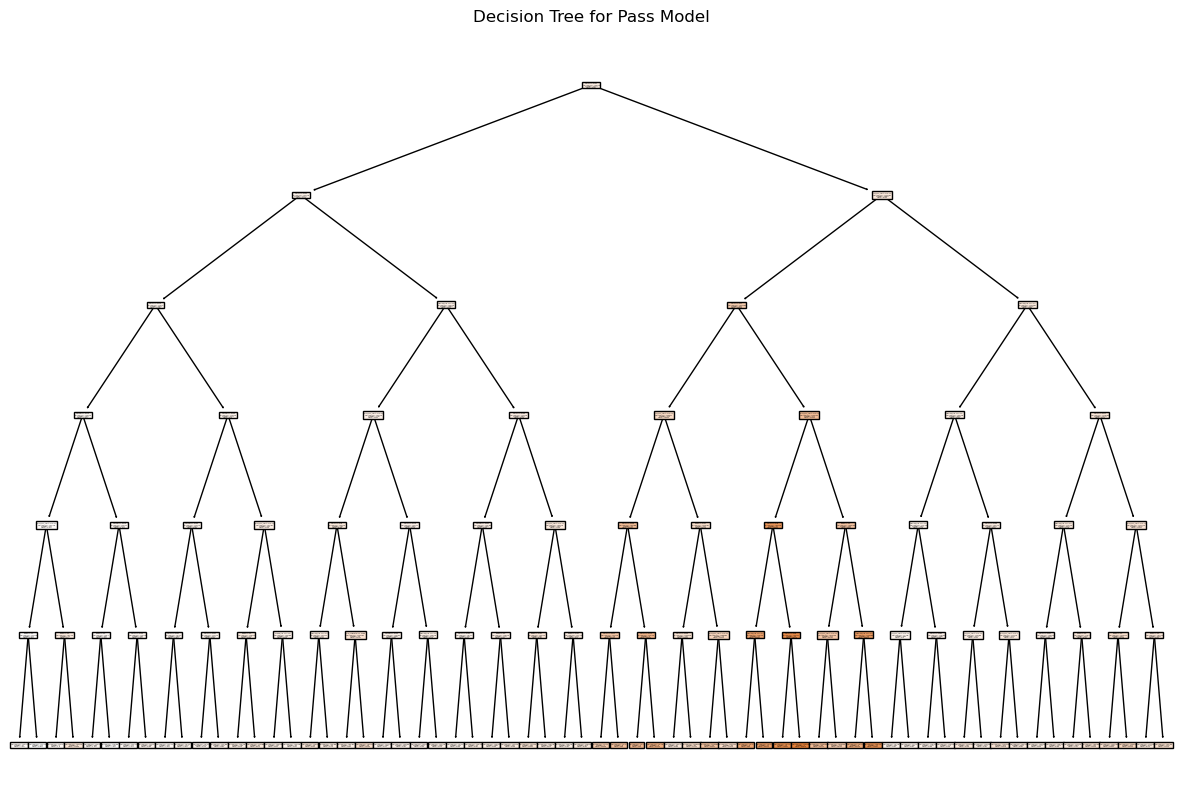

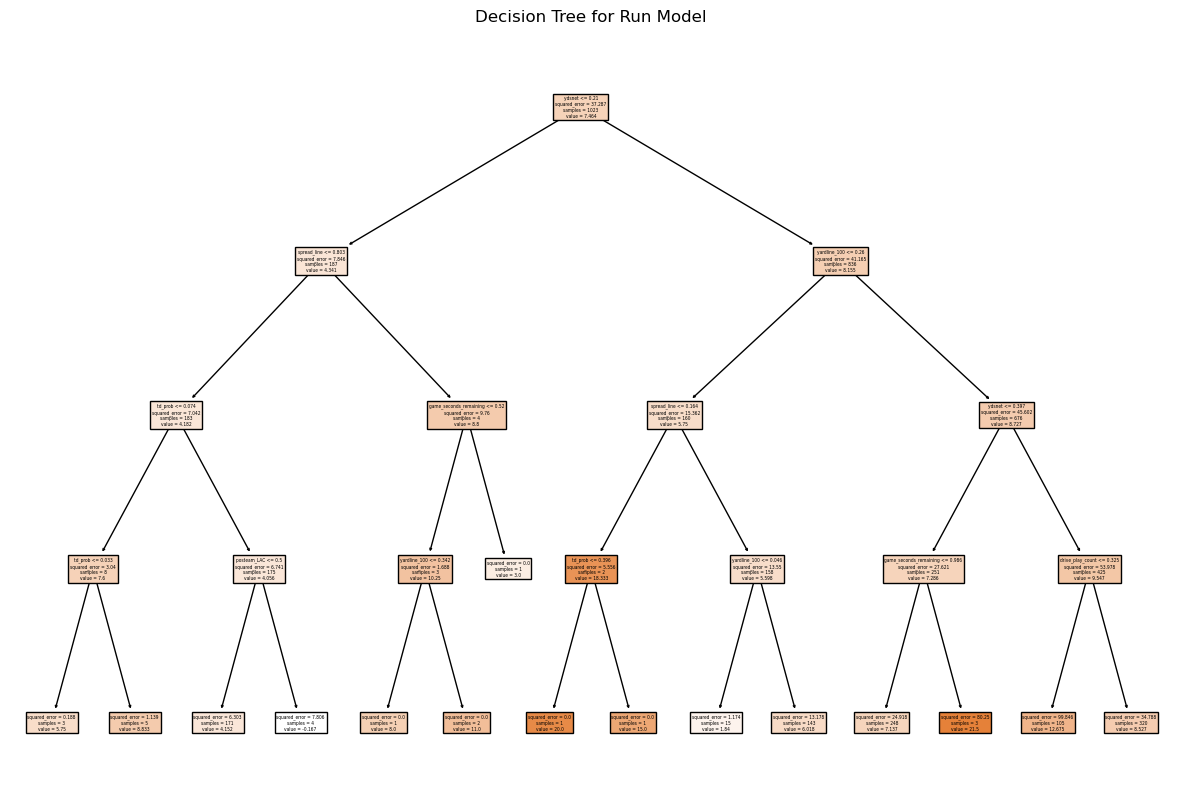

In [181]:
# visualize decision tree
# test model
test_model(run_pipeline, run_X_train, run_y_train, run_X_test, run_y_test)
test_model(pass_pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# Access a specific tree from the forest (e.g., the first tree)
tree_to_plot_pass = 0
tree_to_plot_run = 0

pass_rf_regressor = pass_pipeline.named_steps['regressor']
run_rf_regressor = run_pipeline.named_steps['regressor']

# Access the decision tree from the Random Forest
individual_tree_pass = pass_rf_regressor.estimators_[tree_to_plot_pass]
individual_tree_run = run_rf_regressor.estimators_[tree_to_plot_run]

# Plot the decision tree for passes
plot_decision_tree(individual_tree_pass, LABEL_PASS)

# Plot the decision tree for runs
plot_decision_tree(individual_tree_run, LABEL_RUN)

### XGBoost

Mean Squared Error: 42.439921049724326
Mean Absolute Error: 4.079395684623534
Root Mean Squared Error: 6.514592930469587
Mean Squared Error: 102.70765076034354
Mean Absolute Error: 7.204958093773037
Root Mean Squared Error: 10.134478317128295


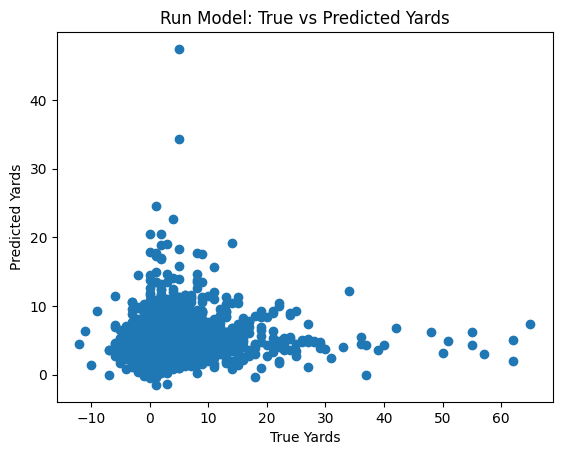

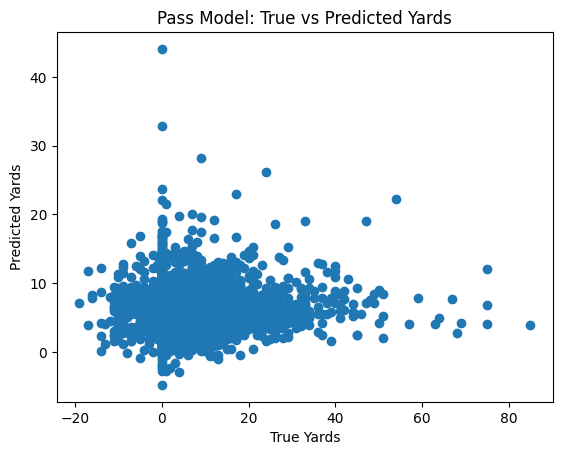

In [10]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

# add model to pipeline
run_pipeline.steps.append(("gradientBoosting", xgb.XGBRegressor(learning_rate = 0.022,
                           n_estimators  = 1000,
                           max_depth     = 8,
                           eval_metric='rmsle')))
pass_pipeline.steps.append(("gradientBoosting", xgb.XGBRegressor(learning_rate = 0.015,
                           n_estimators  = 1000,
                           max_depth     = 8,
                           eval_metric='rmsle')))

# test model and save predictions
run_predictions = test_model(run_pipeline, run_X_train, run_y_train, run_X_test, run_y_test)
pass_predictions = test_model(pass_pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# visualize predictions
visualize_predicts(run_y_test, run_predictions, LABEL_RUN)
visualize_predicts(pass_y_test, pass_predictions, LABEL_PASS)

In [13]:
# estimating hyperparameters

run_features, run_target = split_feature_target(run_df, 0.05)
pass_features, pass_target = split_feature_target(pass_df, 0.05)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
run_pipeline.steps.append(('gradientBoosting', xgb.XGBRegressor()))

parameters = {
    "gradientBoosting__max_depth":    [8, 10],
    "gradientBoosting__n_estimators": [1000, 1100],
    "gradientBoosting__learning_rate": [0.022, 0.015]
}

#def estimate_hyperparams(features, target, pipeline, scoring, k_folds=5, parameters={}):

run_estimator = estimate_hyperparams(run_features, run_target, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)
#pass_estimator = estimate_hyperparams(pass_features, pass_target, pass_model, 0.05, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)

display(run_estimator.best_params_)
display(pd.DataFrame(run_estimator.cv_results_))
#display(pass_estimator.best_params_)

{'gradientBoosting__learning_rate': 0.015,
 'gradientBoosting__max_depth': 8,
 'gradientBoosting__n_estimators': 1000}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientBoosting__learning_rate,param_gradientBoosting__max_depth,param_gradientBoosting__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.326958,0.028938,0.019041,0.003270,0.022,8,1000,"{'gradientBoosting__learning_rate': 0.022, 'gr...",-7.399286,-6.582620,-6.094462,-6.692123,0.538290,3
1,1.464404,0.041262,0.018205,0.001929,0.022,8,1100,"{'gradientBoosting__learning_rate': 0.022, 'gr...",-7.407131,-6.590170,-6.103459,-6.700254,0.537884,4
2,1.976983,0.090125,0.019027,0.000816,0.022,10,1000,"{'gradientBoosting__learning_rate': 0.022, 'gr...",-7.423521,-6.751266,-6.180474,-6.785087,0.508035,7
3,2.202011,0.045491,0.025208,0.003484,0.022,10,1100,"{'gradientBoosting__learning_rate': 0.022, 'gr...",-7.425185,-6.752630,-6.183267,-6.787027,0.507594,8
4,1.372208,0.015680,0.016200,0.001437,0.015,8,1000,"{'gradientBoosting__learning_rate': 0.015, 'gr...",-7.351087,-6.541430,-6.112385,-6.668301,0.513594,1
5,1.528232,0.015303,0.017031,0.002168,0.015,8,1100,"{'gradientBoosting__learning_rate': 0.015, 'gr...",-7.374593,-6.552341,-6.128526,-6.685153,0.517301,2
6,2.004344,0.096749,0.021210,0.001656,0.015,10,1000,"{'gradientBoosting__learning_rate': 0.015, 'gr...",-7.405019,-6.720378,-6.184809,-6.770069,0.499386,5
7,2.282660,0.079343,0.021883,0.002252,0.015,10,1100,"{'gradientBoosting__learning_rate': 0.015, 'gr...",-7.416725,-6.727766,-6.188552,-6.777681,0.502640,6


### Artificial Neuronal Network

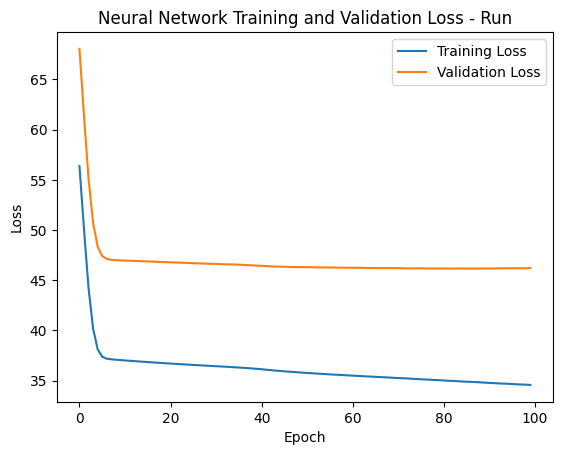

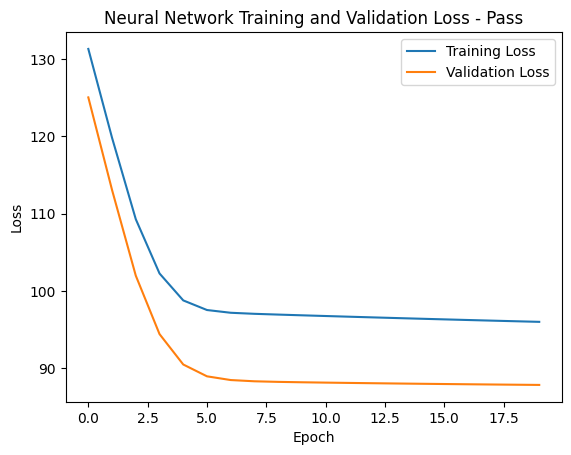

Mean Squared Error (MSE) for run plays: 37.3851469390685
Mean Squared Error (MSE) for pass plays: 95.28860685069219


In [14]:
# Basic model

run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_pipeline.steps.append(('regressor', MLPWithHistory(
    mlp_params={
        'hidden_layer_sizes': (10, ), 
        'max_iter': 100, 
        'solver': 'adam', 
        'activation': 'relu', 
        'random_state': 42
    }
)))

pass_pipeline.steps.append(('regressor', MLPWithHistory(
    mlp_params={
        'hidden_layer_sizes': (10, ), 
        'max_iter': 20, 
        'solver': 'adam', 
        'activation': 'relu', 
        'random_state': 42
    }
)))

# Fit the pipelines
run_pipeline.fit(run_X_train, run_y_train)
pass_pipeline.fit(pass_X_train, pass_y_train)

run_mlp = run_pipeline.named_steps['regressor']
pass_mlp = pass_pipeline.named_steps['regressor']

# Plot the training and validation loss
visualize_train_val_loss(run_mlp.training_losses, run_mlp.validation_losses, LABEL_RUN)
visualize_train_val_loss(pass_mlp.training_losses, pass_mlp.validation_losses, LABEL_PASS)

# Evaluate the neural network for run plays
y_run_pred = run_pipeline.predict(run_X_test)
mse_run = mean_squared_error(run_y_test, y_run_pred)
print(f"Mean Squared Error (MSE) for run plays: {mse_run}")

# Evaluate the neural network for pass plays
y_pass_pred = pass_pipeline.predict(pass_X_test)
mse_pass = mean_squared_error(pass_y_test, y_pass_pred)
print(f"Mean Squared Error (MSE) for pass plays: {mse_pass}")


In [16]:
# estimating hyperparameters

run_features, run_target = split_feature_target(run_df, 0.01)
pass_features, pass_target = split_feature_target(pass_df, 0.01)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline()
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline()

run_model = MLPWithHistory()
pass_model = MLPWithHistory()

run_pipeline.steps.append(('regressor', run_model))
pass_pipeline.steps.append(('regressor', pass_model))

parameters = {
    'regressor__mlp_params': [
        {'hidden_layer_sizes': (10,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
        {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
        {'hidden_layer_sizes': (10, 5), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
        {'hidden_layer_sizes': (20, 10), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
    ]
}

run_estimator = estimate_hyperparams(run_features, run_target, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)
pass_estimator = estimate_hyperparams(pass_features, pass_target, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)

display(run_estimator.best_params_)
display(pd.DataFrame(run_estimator.cv_results_))
display(pass_estimator.best_params_)
display(pd.DataFrame(pass_estimator.cv_results_))

{'regressor__mlp_params': {'hidden_layer_sizes': (10, 5),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__mlp_params,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.106021,0.004985,0.004007,0.000408,"{'hidden_layer_sizes': (10,), 'activation': 'r...",{'regressor__mlp_params': {'hidden_layer_sizes...,-7.975294,-5.341802,-5.454908,-6.257335,1.215658,2
1,0.210313,0.006505,0.004918,0.001200,"{'hidden_layer_sizes': (50,), 'activation': 'r...",{'regressor__mlp_params': {'hidden_layer_sizes...,-7.910192,-5.372588,-5.599646,-6.294142,1.146474,3
2,0.121401,0.003590,0.012205,0.013018,"{'hidden_layer_sizes': (10, 5), 'activation': ...",{'regressor__mlp_params': {'hidden_layer_sizes...,-7.983454,-5.323760,-5.449706,-6.252307,1.225185,1
3,0.130130,0.002244,0.004197,0.000660,"{'hidden_layer_sizes': (20, 10), 'activation':...",{'regressor__mlp_params': {'hidden_layer_sizes...,-7.950757,-5.423676,-5.583963,-6.319466,1.155352,4


{'regressor__mlp_params': {'hidden_layer_sizes': (10,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__mlp_params,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.110558,0.002305,0.004004,0.000409,"{'hidden_layer_sizes': (10,), 'activation': 'r...",{'regressor__mlp_params': {'hidden_layer_sizes...,-8.176589,-8.980175,-8.223170,-8.459978,0.368326,1
1,0.202563,0.000707,0.004007,0.000712,"{'hidden_layer_sizes': (50,), 'activation': 'r...",{'regressor__mlp_params': {'hidden_layer_sizes...,-8.289194,-9.047822,-8.451827,-8.596281,0.326118,3
2,0.121696,0.001263,0.019857,0.022065,"{'hidden_layer_sizes': (10, 5), 'activation': ...",{'regressor__mlp_params': {'hidden_layer_sizes...,-8.200519,-9.009758,-8.345900,-8.518726,0.352249,2
3,0.145205,0.007713,0.004008,0.000411,"{'hidden_layer_sizes': (20, 10), 'activation':...",{'regressor__mlp_params': {'hidden_layer_sizes...,-8.294136,-9.024221,-8.486247,-8.601535,0.309003,4


Mean Squared Error: 38.41531973264254
Mean Absolute Error: 3.7470275972466665
Root Mean Squared Error: 6.198009336282299
Mean Squared Error: 99.81018730789826
Mean Absolute Error: 7.0483106707653755
Root Mean Squared Error: 9.990504857508366


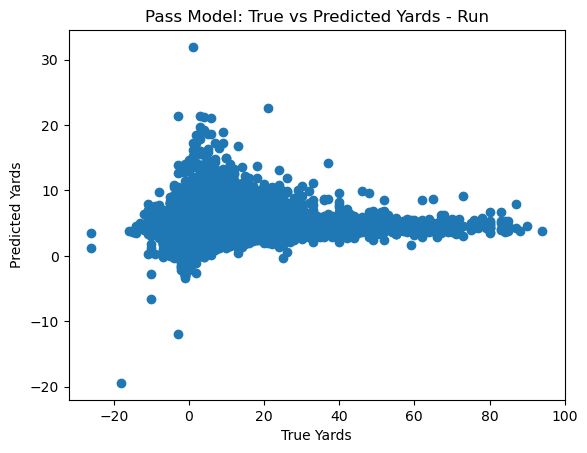

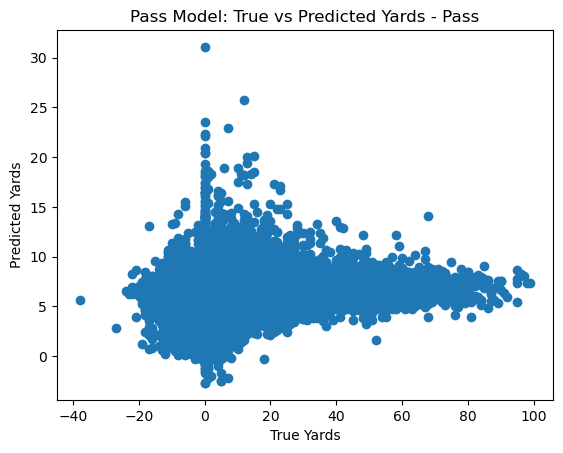

{'learning_rate': 0.022, 'max_depth': 8, 'n_estimators': 1000}

{'learning_rate': 0.015, 'max_depth': 8, 'n_estimators': 1000}